In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt 
import seaborn as sns 
import copy 
import time
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.utils.data as Data 
from torchvision import transforms 
from torchvision.datasets import FashionMNIST,Flowers102
from torch.optim.lr_scheduler import LambdaLR

from module.ResNet_CBAM import resnet18_cbam
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# 复现性
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

torch.Size([64, 3, 192, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


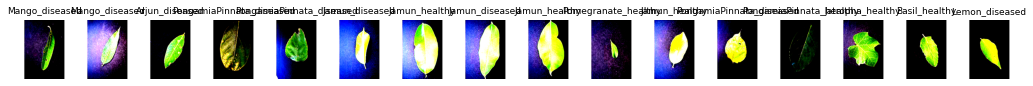

In [2]:
import glob
import os
from PIL import Image

class_leaf = ['AlstoniaScholaris_diseased','AlstoniaScholaris_healthy','Arjun_diseased','Arjun_healthy',
'Bael_diseased','Basil_healthy','Chinar_diseased','Chinar_healthy','Gauva_diseased','Gauva_healthy','Jamun_diseased','Jamun_healthy'
,'Jatropha_diseased','Jatropha_healthy','Lemon_diseased','Lemon_healthy','Mango_diseased','Mango_healthy',
'Pomegranate_diseased','Pomegranate_healthy','PongamiaPinnata_diseased','PongamiaPinnata_healthy']
train_image_path = "D:\\Data\\test2"
valid_image_path = "D:\\Data\\test2"
image_format = "JPG"
batch_size = 64
num_workers = 0

def default_loader(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

class Dataset:

    def __init__(self, image_root_path, data_transforms=None, image_format='JPG'):
        self.data_transforms = data_transforms
        self.image_root_path = image_root_path
        self.image_format = image_format
        self.images = []
        self.labels = []
        classes_folders = os.listdir(self.image_root_path)
        for cls_folder in classes_folders:
            folder_path = os.path.join(self.image_root_path, cls_folder)
            if os.path.isdir(folder_path):
                images_path = os.path.join(folder_path, "*.{}".format(self.image_format))
                images = glob.glob(images_path)
                self.images.extend(images)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, item):
        image_file = self.images[item]
        label_name = os.path.basename(os.path.dirname(image_file))
        image = default_loader(image_file)
        if self.data_transforms is not None:
            image = self.data_transforms(image)

        return image, int(label_name)

train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        #transforms.RandomRotation(degrees=(0, 30)),
        #transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.IMAGENET), 
        #transforms.RandAugment(),
        transforms.ToTensor(), # [0.23514299 0.26522756 0.24338898] [0.12180319 0.14363708 0.11331236]
        transforms.Normalize(mean=[0.23514299,0.26522756,0.24338898], std=[0.12180319,0.14363708,0.11331236])  # 各通道颜色的均值和方差,用于归一化
    ])
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.23514299,0.26522756,0.24338898], std=[0.12180319,0.14363708,0.11331236])  # 各通道颜色的均值和方差,用于归一化
    ])
train_dataset = Dataset(train_image_path, train_transform, image_format)
valid_dataset = Dataset(valid_image_path, valid_transform, image_format)

train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size,
        shuffle=True, num_workers=num_workers,
    )
valid_dataloader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size,
        shuffle=True, num_workers=num_workers
    )   

img,lab = next(iter(train_dataloader))
print(img.shape)

plt.figure(figsize = (18, 5))
for i in np.arange(16):
    plt.subplot(4, 16, i + 1)
    plt.imshow(img[i].transpose(0,2))
    plt.title(class_leaf[lab[i]], size = 9)
    plt.axis('off')
    plt.subplots_adjust(wspace = 0.05)


In [22]:
# 计算图像的标准化
def get_mean_std(dataset, ratio=0.85):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=int(len(dataset) * ratio),
                                             shuffle=True, num_workers=0)
    data = iter(dataloader).next()[0]  # 一个batch的数据

    mean = np.mean(data.numpy(), axis=(0, 2, 3))
    std = np.std(data.numpy(), axis=(0, 2, 3))
    return mean, std

if __name__ == '__main__':
                                            
    time0 = time.time()
    train_mean, train_std = get_mean_std(train_dataset)
    test_mean, test_std = get_mean_std(valid_dataset)
    time1 = time.time()
    time = time1 - time0
    print(time)
    print(train_mean, train_std)
    print(test_mean, test_std)

11.080876111984253
[0.23514299 0.26522756 0.24338898] [0.12180319 0.14363708 0.11331236]
[0.23532057 0.26537094 0.24328896] [0.12178781 0.143658   0.11356808]


In [ ]:
train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # 各通道颜色的均值和方差,用于归一化
    ])
valid_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # 各通道颜色的均值和方差,用于归一化
    ])

train_data = Flowers102(
    root = 'D:\\数据\\Flowers102',
    split= "train",
    transform = train_transform
)
# 定义一个数据加载器
train_loader = Data.DataLoader(
    dataset = train_data,   # 数据集
    batch_size = 8,    # 批量处理的大小
    shuffle = True,   # 不打乱数据
    num_workers = 0,    # 两个进程
)

label = train_data._labels
# print(label)
# 处理测试集
test_data = FashionMNIST(
    root = 'D:\\数据\\Flowers102',
    train = False, # 不使用训练数据集
    transform = transforms.ToTensor(),
    download = False
)

test_loader = Data.DataLoader(
    dataset = test_data,   # 数据集
    batch_size = 8,    # 批量处理的大小
)
img,lab = next(iter(train_loader))

plt.figure(figsize = (12, 5))
for i in np.arange(16):
    plt.subplot(4, 16, i + 1)
    plt.imshow(img[i].transpose(0,2))
    plt.title(label[lab[i]], size = 9)
    plt.axis('off')
    plt.subplots_adjust(wspace = 0.05)

torch.Size([256, 1, 28, 28])
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


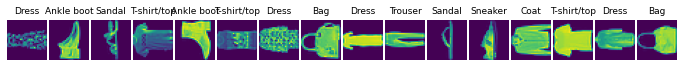

In [4]:
train_transform = transforms.Compose([
            transforms.RandomAutocontrast(),
            transforms.RandomGrayscale(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            ])
# transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
test_transform = transforms.Compose([
            transforms.ToTensor(),
            ])

train_data = FashionMNIST(
    root = 'D:\\数据\\FashionMNIST',
    train=True,
    transform = train_transform,
    download = False
)
# 处理测试集
test_data = FashionMNIST(
    root = 'D:\\数据\\FashionMNIST',
    train = False, # 不使用训练数据集
    transform = test_transform,
    download = False
)
# 定义一个数据加载器
train_loader = Data.DataLoader(
    dataset = train_data,   # 数据集
    batch_size = 256,    # 批量处理的大小
    shuffle = True,   # 不打乱数据
    num_workers = 0,    # 两个进程
    pin_memory=True,
    drop_last=True
)
test_loader = Data.DataLoader(
    dataset = test_data,   # 数据集
    batch_size = 256,    # 批量处理的大小
    num_workers = 0,  
    shuffle = True, 
    pin_memory=True,
    drop_last=True
)

label = train_data.classes
img,lab = next(iter(train_loader))
print(img.shape)

plt.figure(figsize = (12, 5))
for i in np.arange(16):
    plt.subplot(4, 16, i + 1)
    plt.imshow(img[i].transpose(0,2))
    plt.title(label[lab[i]], size = 9)
    plt.axis('off')
    plt.subplots_adjust(wspace = 0.05)
print(label)

In [4]:
# 定义网络训练过程函数
def train_model(model, traindataloader, testdataloader,scheduler,criterion, optimizer, num_epochs = 25):
    '''
    模型，训练数据集(待切分)，训练集百分比，损失函数，优化器，训练轮数
    '''
    # 复制模型参数
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss_all = []
    val_loss_all =[]
    train_acc_all = []
    val_acc_all = []
    since = time.time()
    # 训练框架
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        train_loss = 0.0 
        train_corrects = 0
        train_num = 0
        val_loss = 0.0
        val_corrects = 0
        val_num = 0
        for step, (b_x, b_y) in enumerate(traindataloader):
             b_x = b_x.to(device=device)
             b_y = b_y.to(device=device)
             model.train()   # 设置为训练模式
             output = model(b_x)
             pre_lab = torch.argmax(output, 1)
             loss = criterion(output, b_y)   # 计算误差损失
             optimizer.zero_grad()   # 清空过往梯度
             loss.backward() # 误差反向传播
             optimizer.step()    # 根据误差更新参数
             train_loss += loss.item() * b_x.size(0)
             train_corrects += torch.sum(pre_lab == b_y.data)
             train_num += b_x.size(0)   
        model.eval()    # 设置为验证模式
        with torch.no_grad():
            for data in testdataloader:
               imgs,targets = data
               imgs = imgs.to(device)
               targets = targets.to(device)
               outputs = model(imgs)
               loss = criterion(outputs,targets)
               val_loss += loss.item() * b_x.size(0)
               val_corrects += torch.sum(pre_lab == b_y.data)
               val_num += b_x.size(0)                       
        scheduler.step()
        # ======================小循环结束========================

        # 计算一个epoch在训练集和验证集上的损失和精度
        train_loss_all.append(train_loss / train_num)
        train_acc_all.append(train_corrects.double().item() / train_num)
        val_loss_all.append(val_loss / val_num)
        val_acc_all.append(val_corrects.double().item() / val_num)
        print('{} Train Loss: {:.4f} Train Acc: {:.4f}'.format(epoch, train_loss_all[-1], train_acc_all[-1]))
        print('{} Val Loss: {:.4f} Val Acc: {:.4f}'.format(epoch, val_loss_all[-1], val_acc_all[-1]))

        # 拷贝模型最高精度下的参数
        if val_acc_all[-1] > best_acc:
            best_acc = val_acc_all[-1]
            best_model_wts = copy.deepcopy(model.state_dict())
        time_use = time.time() - since
        print('Train and Val complete in {:.0f}m {:.0f}s'.format(time_use // 60, time_use % 60))
    # ===========================大循环结束===========================


    # 使用最好模型的参数
    model.load_state_dict(best_model_wts)
    train_process = pd.DataFrame(
        data = {'epoch': range(num_epochs),
                'train_loss_all': train_loss_all,
                'val_loss_all': val_loss_all,
                'train_acc_all': train_acc_all,
                'val_acc_all': val_acc_all})
    return model, train_process

In [5]:
import math
# 对模型进行训练
model = resnet18_cbam(pretrained=False)
# 再次训练
load_dictx = torch.load("D:\\数据\\model3.pth")
model.load_state_dict(load_dictx)
model = model.to(device=device)


lr = 0.001
Max_epochs = 16

#optimizer = Adam(model.parameters(), lr=lr,weight_decay=0.0005)
optimizer = torch.optim.SGD(model.parameters(),lr=lr,momentum=0.9,weight_decay=0.0005)

"""设置lr策略"""
def one_cycle(y1=0.0, y2=1.0, steps=100):
    # lambda function for sinusoidal ramp from y1 to y2 https://arxiv.org/pdf/1812.01187.pdf
    return lambda x: ((1 - math.cos(x * math.pi / steps)) / 2) * (y2 - y1) + y1

lr_lambda = lambda epoch: ((1 + math.cos(epoch * math.pi / Max_epochs)) / 2) * (1 - 0.01) + 0.01
#scheduler = LambdaLR(optimizer=optimizer,lr_lambda=lr_lambda)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, last_epoch=-1, verbose=False)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, one_cycle(1,0.1,Max_epochs), last_epoch=-1, verbose=False)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, 0.1, verbose=True)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.65 , verbose=False)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device=device)

#mymodel, train_process = train_model(model, train_loader, test_loader,scheduler,criterion, optimizer, num_epochs = Max_epochs)
mymodel,train_process = train_model(model, train_dataloader,valid_dataloader,scheduler,criterion, optimizer, num_epochs = Max_epochs)

# # 保存模型结构+权重参数
torch.save(model, "D:\\数据\\model.pth")
# # 保存权重
torch.save(model.state_dict(),"D:\\数据\\model3.pth")

Epoch 0/15
----------
0 Train Loss: 0.3405 Train Acc: 0.8896
0 Val Loss: 0.2791 Val Acc: 0.7727
Train and Val complete in 0m 26s
Epoch 1/15
----------
1 Train Loss: 0.3044 Train Acc: 0.9049
1 Val Loss: 0.2665 Val Acc: 0.9545
Train and Val complete in 0m 50s
Epoch 2/15
----------
2 Train Loss: 0.2953 Train Acc: 0.9087
2 Val Loss: 0.2593 Val Acc: 0.8182
Train and Val complete in 1m 14s
Epoch 3/15
----------
3 Train Loss: 0.2903 Train Acc: 0.9087
3 Val Loss: 0.2511 Val Acc: 0.8636
Train and Val complete in 1m 38s
Epoch 4/15
----------
4 Train Loss: 0.2794 Train Acc: 0.9116
4 Val Loss: 0.2479 Val Acc: 0.7727
Train and Val complete in 2m 2s
Epoch 5/15
----------
5 Train Loss: 0.2787 Train Acc: 0.9143
5 Val Loss: 0.2449 Val Acc: 0.8636
Train and Val complete in 2m 25s
Epoch 6/15
----------
6 Train Loss: 0.2718 Train Acc: 0.9125
6 Val Loss: 0.2406 Val Acc: 0.8636
Train and Val complete in 2m 50s
Epoch 7/15
----------
7 Train Loss: 0.2748 Train Acc: 0.9165
7 Val Loss: 0.2399 Val Acc: 0.7727
Tr

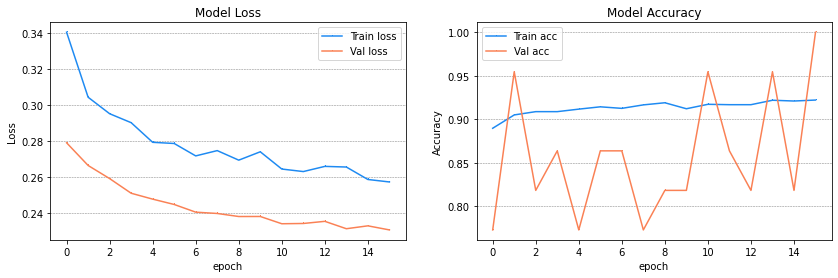

In [6]:
# 可视化训练过程
plt.figure(figsize = (14, 4))
plt.subplot(1, 2, 1)
plt.grid(True,linestyle="--",color="gray",linewidth="0.5",axis="y")
plt.plot(train_process.epoch, train_process.train_loss_all, color="#1E8AF2",marker=',', label = 'Train loss')
plt.plot(train_process.epoch, train_process.val_loss_all, color="#FA8155",marker=',', label = 'Val loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Model Loss')


plt.subplot(1, 2, 2)
plt.grid(True,linestyle="--",color="gray",linewidth="0.5",axis="y")
plt.plot(train_process.epoch, train_process.train_acc_all, color="#1E8AF2",marker=',', label = 'Train acc')
plt.plot(train_process.epoch, train_process.val_acc_all, color="#FA8155",marker=',', label = 'Val acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.savefig("D://train.tif",dpi=200)

In [32]:
import pandas as pd
#创建train_acc.csv
df = pd.DataFrame(columns=['epoch','train_loss_all','val_loss_all','train_acc_all','val_acc_all'])#列名
df.to_csv("D:\\train_acc.csv",index=False) 
#由于DataFrame是Pandas库中的一种数据结构，它类似excel，是一种二维表，所以需要将list以二维列表的形式转化为DataFrame
data = pd.DataFrame({ # 按照列写出数据
    'epoch':train_process.epoch.tolist(),
    'train_loss':train_process.train_loss_all.tolist(),
    'val_loss':train_process.val_loss_all.tolist(),
    'train_acc':train_process.train_acc_all.tolist(),
    'val_acc':train_process.val_acc_all.tolist(),
})
data.to_csv('D:\\train_acc.csv',mode='a',header=False,index=False,sep= ',')#mode设为a,就可以向csv文件追加数据了

In [6]:
# 1. 加载的为参数
load_dict = torch.load("D:\\数据\\model3.pth")
net = resnet18_cbam() # 手动加载结构
net.load_state_dict(load_dict)


# 测试集预测，并可视化预测效果
net.eval()

#img, lab = next(iter(test_loader))
img, lab = next(iter(valid_dataloader))
output = net(img)
print(output.shape)
print(output[0].sum())
pre_lab = torch.argmax(output, 1)
acc = accuracy_score(lab.cpu(), pre_lab.cpu())
print(lab)
print(pre_lab)
print('测试集上的预测精度为', acc)

torch.Size([64, 22])
tensor(-340.0985, grad_fn=<SumBackward0>)
tensor([16,  6, 20, 11,  9, 18, 16, 16, 21, 11,  8, 20, 16, 11,  1, 19,  7, 20,
         6,  0, 15, 16, 16, 14, 16, 10, 21,  3, 16, 12,  0,  0, 14,  8, 15, 18,
        13, 20, 19,  0,  2,  3, 17, 20, 12,  9, 11, 16,  5, 18,  0, 16, 15, 21,
         9, 17, 19,  9, 16,  8,  7, 13, 19, 10])
tensor([16,  6, 20, 11,  9, 18, 16, 16, 21, 11,  8, 20, 16, 11,  1, 19,  7, 20,
         6,  0, 15, 16, 16, 14, 16, 10, 21,  3, 16, 20,  0,  0, 15,  8, 15, 18,
        13, 20, 19,  0,  2,  3, 17, 20, 13,  9, 11, 16,  5, 18,  0, 16, 15, 21,
         9, 17, 19,  9, 16,  8,  7, 13, 19, 10])
测试集上的预测精度为 0.953125


In [4]:
# 人工数据集
lab = [ 8, 17, 19, 17, 19, 14,  1, 12,  4, 21,  0,  0,  9, 19,  3,  5,  5, 19,
        10, 20, 10, 14, 16,  4, 15,  0, 17,  2,  2, 13,  1, 16,  0, 20,  0, 10,
        17, 10, 16, 19, 14,  6,  9, 11,  1,  0, 18, 20, 21, 19,  1,  3, 15,  5,
         3,  0, 17,  1, 20, 10, 13,  6, 13,  1]
pre_lab = [ 8, 17, 19, 17, 19, 14,  1, 11,  4, 21,  0,  0, 9, 19,  3,  5, 5, 19,
        10, 20, 10,  14, 16,  4, 15,  0, 17,  2,  2,  13,  1, 16,  0, 20,  0, 10,
         1, 10, 16, 19,  14, 6,  9, 11,  1,  0, 18, 20, 21, 19,  1,  3,  15,  5,
         2,  1, 17,  1, 20, 10,  7,  6,  1,  1]
acc = accuracy_score(lab, pre_lab)
print('测试集上的预测精度为', acc)

测试集上的预测精度为 0.90625


输出精度 0.93359375
torch.Size([256])


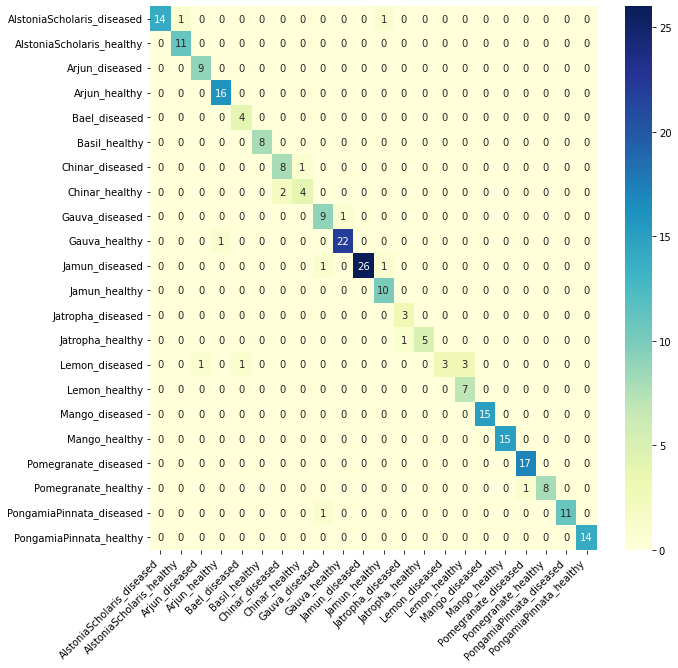

In [5]:
# 计算测试集上的混淆矩阵并可视化

test_dataloader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=256,
        shuffle=True, num_workers=num_workers
    )   
img_t, lab_t = next(iter(test_dataloader))
output = net(img_t)
pre_labt = torch.argmax(output, 1)
acc2 = accuracy_score(lab_t.cpu(), pre_labt.cpu())
print('输出精度',acc2)
plt.figure(figsize = (10, 10))
plt.ylabel('True label')
plt.xlabel('Predicted label')
#conf_mat = confusion_matrix(lab.cpu(), pre_lab.cpu())
conf_mat = confusion_matrix(lab_t, pre_labt) # 输出报错的原因当时可能 没有拿到该类别
print(pre_labt.shape)
df_cm = pd.DataFrame(conf_mat, index = class_leaf, columns = class_leaf)
heatmap = sns.heatmap(df_cm, annot = True, fmt = 'd', cmap = 'YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 45, ha = 'right')

plt.savefig("D://boxplot.tif",dpi=200)

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
accuracy值为 0.926667
recall值为 0.926667
precision值为 0.926667
kappa值为 0.922439
F1_value tensor(0.9267)

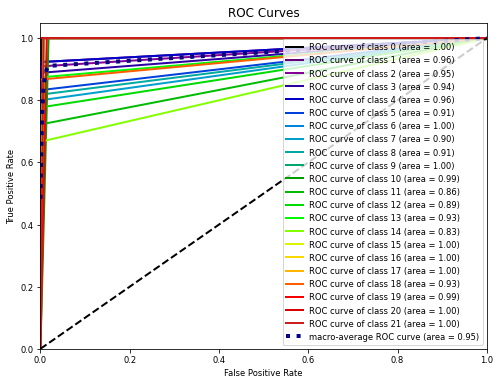

In [3]:
import scikitplot as skplt
from sklearn.metrics import precision_recall_curve,recall_score,precision_score,cohen_kappa_score,classification_report
import matplotlib.pyplot as plt
from torchmetrics import F1Score,Specificity

# lab_t, pre_labt
# lab_t = np.asarray(pre_labt) 
# lab_t = np.asarray(lab_t)

# 1. 加载的为参数
load_dict = torch.load("D:\\数据\\model2.pth")
net = resnet18_cbam() # 手动加载结构
net.load_state_dict(load_dict)

test_dataloader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=300,
        shuffle=True, num_workers=num_workers
    )   
img_t, lab_t = next(iter(test_dataloader))
output = net(img_t)
pre_labt = torch.argmax(output, 1)


list_pre_labt= list(pre_labt.cpu().numpy())
list_lab_t= list(lab_t.cpu().numpy())


final_res = []
# 建立准确率预测结构
for preb in list_pre_labt:
    result = []
    for i in range(300):
       result.append(0)
    result[preb]=1
    final_res.append(result)

print(final_res[0])

accuracy_value = accuracy_score(list_lab_t, list_pre_labt)
print("accuracy值为 %f" % accuracy_value)

recall_value = recall_score(list_lab_t, list_pre_labt,average="micro")
print("recall值为 %f" % recall_value)

precision_value = precision_score(list_lab_t, list_pre_labt,average="micro")
print("precision值为 %f" % precision_value)

kappa_value = cohen_kappa_score(list_lab_t, list_pre_labt)
print("kappa值为 %f" % kappa_value)

F1 = F1Score(num_classes=22)
F1_value = F1(pre_labt, lab_t)
print("F1_value %s" % F1_value)

specificity = Specificity(average='micro', num_classes=22)
specificity_value = specificity(pre_labt, lab_t)
print("specificity_value %s" % specificity_value)

report_value = classification_report(list_lab_t, list_pre_labt,target_names=class_leaf,digits=4)
print("report_value值为 %s" % report_value)


skplt.metrics.plot_roc(list_lab_t, final_res,figsize=(8, 6),plot_macro=True,plot_micro=False,text_fontsize="small")
plt.savefig("D://ROC.tiff",dpi=200,bbox_inches = 'tight')#解决图片不清晰，不完整的问题
